In [4]:
#Import the librairies
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt

import seaborn as sns

#Import the dataset
data = 'flight_data_2024_sample.csv'
flight_df = pd.read_csv(data)
print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm  ...  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  ...   
1              148.0    CLT          Charlotte, NC  North Carolina  ...   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ...   
3             1971.0    OMA              Omaha, NE        Nebraska  ...   
4              862.0    BWI          Baltimore, MD        Maryland  ...   

  diverted crs_elapsed_time actual_elapsed_time  air_time  distance  \
0        0            151.0

## Clean the Dataset

### Remove none important independent variables

In [5]:
print(flight_df.columns)

flight_df.drop(['taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
    'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'], axis=1, inplace=True)
print(flight_df.columns)

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')
Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_nm', 'dest', 'dest_city_name', 'dest_state_nm',
       'crs_dep_time', 'dep_time', 'dep_delay', 'cancelled', 'distance'],
      dtype='object')


### Remove cancelled flights

In [6]:
flight_df = flight_df[flight_df['cancelled'] == 0]

print(flight_df)

      year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0     2024      4            18            4  2024-04-18                MQ   
1     2024      1             1            1  2024-01-01                AA   
2     2024     12            12            4  2024-12-12                9E   
3     2024      4             8            1  2024-04-08                WN   
4     2024      2            16            5  2024-02-16                WN   
...    ...    ...           ...          ...         ...               ...   
9995  2024      1            16            2  2024-01-16                WN   
9996  2024      7             5            5  2024-07-05                AA   
9997  2024      2            28            3  2024-02-28                MQ   
9998  2024      2            18            7  2024-02-18                DL   
9999  2024      3             1            5  2024-03-01                G4   

      op_carrier_fl_num origin       origin_city_name origin_st

## Create new categories

In [7]:
flight_df['flight_delayed'] = (flight_df['dep_delay'] > 0).astype(int)
print(flight_df.head())

   year  month  day_of_month  day_of_week     fl_date op_unique_carrier  \
0  2024      4            18            4  2024-04-18                MQ   
1  2024      1             1            1  2024-01-01                AA   
2  2024     12            12            4  2024-12-12                9E   
3  2024      4             8            1  2024-04-08                WN   
4  2024      2            16            5  2024-02-16                WN   

   op_carrier_fl_num origin       origin_city_name origin_state_nm dest  \
0             3535.0    DFW  Dallas/Fort Worth, TX           Texas  RAP   
1              148.0    CLT          Charlotte, NC  North Carolina  PHX   
2             5440.0    CHA        Chattanooga, TN       Tennessee  ATL   
3             1971.0    OMA              Omaha, NE        Nebraska  LAS   
4              862.0    BWI          Baltimore, MD        Maryland  MYR   

     dest_city_name   dest_state_nm  crs_dep_time  dep_time  dep_delay  \
0    Rapid City, SD    S

## Random Forest

In [8]:
from sklearn.model_selection import train_test_split

#Split the data into temp and test sets
temp_df, train_df = train_test_split(flight_df, test_size=0.6, random_state=42)

#Split the data into train and validation sets
test_df, validation_df = train_test_split(temp_df, test_size=0.5, random_state=42)

#Print the shapes
print(f"Train set: {train_df.shape[0]}")
print(f"Validation shape: {validation_df.shape[0]}")
print(f"Test shape: {test_df.shape[0]}")

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random

# Separate predictors (X) and target (y)
X_train = train_df.drop("flight_delayed", axis=1)
y_train = train_df["flight_delayed"]
X_validation = validation_df.drop("flight_delayed", axis=1)
y_validation = validation_df["flight_delayed"]
X_test = test_df.drop("flight_delayed", axis=1)
y_test = test_df["flight_delayed"]

# Encode the categorical columns you want to keep
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['op_unique_carrier', 'origin', 'dest']

for col in categorical_cols:
    # Fit on all data combined
    all_values = pd.concat([X_train[col], X_validation[col], X_test[col]]).astype(str)
    le = LabelEncoder()
    le.fit(all_values)
    
    # Transform each set
    X_train[col] = le.transform(X_train[col].astype(str))
    X_validation[col] = le.transform(X_validation[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# Drop object columns and fl_date
columns_to_drop = ['fl_date', 'origin_city_name', 'origin_state_nm', 'dest_city_name', 'dest_state_nm','dep_delay','crs_dep_time','op_carrier_fl_num']
X_train = X_train.drop(columns_to_drop, axis=1)
X_validation = X_validation.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

# Create the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': np.arange(3, 10, 1),      
    'min_samples_leaf': [0.01, 0.02],
    'max_features': [0.3, 0.5, 0.8, 'sqrt', 'log2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1,
    return_train_score = True
)

# Fit the grid search on the training data
random.seed(42)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf = grid_search.best_estimator_

# Display the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Train set: 5927
Validation shape: 1976
Test shape: 1975
Fitting 5 folds for each of 210 candidates, totalling 1050 fits
Best hyperparameters: {'max_depth': np.int64(7), 'max_features': 0.5, 'min_samples_leaf': 0.01, 'n_estimators': 100}


/var/folders/ls/9r4q2dwx4y7dw37gy3hqq3300000gn/T/ipykernel_10752/873703039.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='crest')


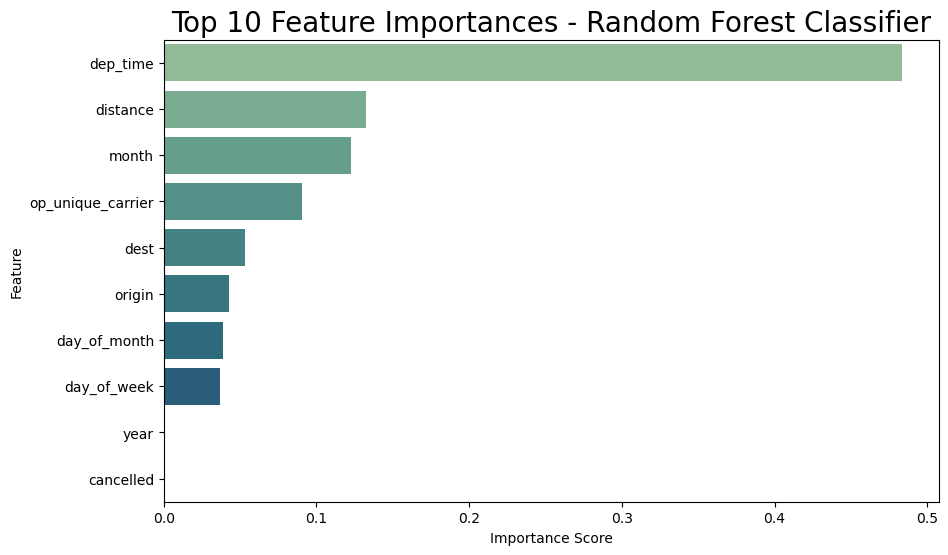

Top 3 Most Important Predictors:
    Feature  Importance
7  dep_time    0.483413
9  distance    0.132162
1     month    0.122763


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances from the tuned Random Forest model
importances = best_rf.feature_importances_

# Create a DataFrame for visualization
feature_importances_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances})

# Sort the DataFrame by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_rf.head(10), palette='crest')
plt.title('Top 10 Feature Importances - Random Forest Classifier', fontsize=20)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display the top 3 predictors
print("Top 3 Most Important Predictors:")
print(feature_importances_rf.head(3))


Test Accuracy: 0.6668


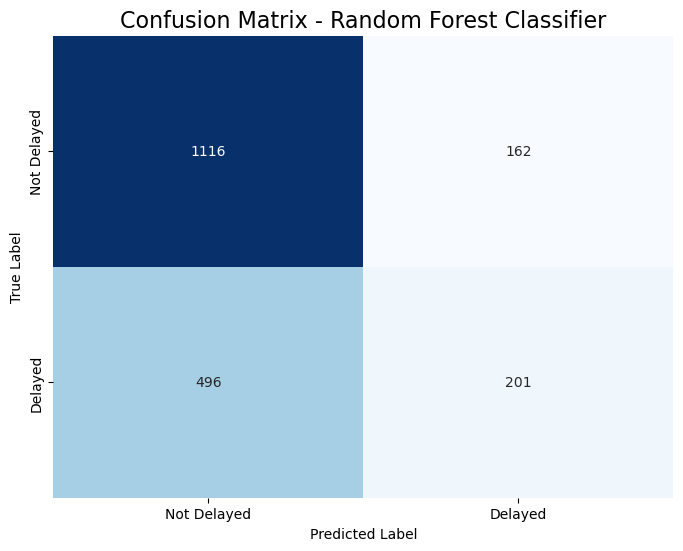


Classification Report:
              precision    recall  f1-score   support

 Not Delayed       0.69      0.87      0.77      1278
     Delayed       0.55      0.29      0.38       697

    accuracy                           0.67      1975
   macro avg       0.62      0.58      0.58      1975
weighted avg       0.64      0.67      0.63      1975



In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test set
y_pred = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Delayed', 'Delayed'],
            yticklabels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=16)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Delayed', 'Delayed']))

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

def classification_evaluation(model, X_train, y_train, X_test, y_test, threshold=0.5):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    test_auc = roc_auc_score(y_test, y_test_pred_proba)
    
    # Print metrics
    print("Train Classification Report:")
    print(classification_report(y_train, y_train_pred))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    # ROC curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, '--', label='Train', linewidth=2)
    plt.plot(fpr_test, tpr_test, '-', label='Test', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('Classification Evaluation Function')
    plt.show()
    
    print("Training ROC AUC score:", train_auc)
    print("Testing ROC AUC score:", test_auc)
    print("Train Accuracy: %.3f" % accuracy_score(y_train, y_train_pred_proba > threshold))
    print("Test Accuracy: %.3f" % accuracy_score(y_test, y_test_pred_proba > threshold))
    print("Train Precision: %.3f" % precision_score(y_train, y_train_pred_proba > threshold))   
    print("Test Precision: %.3f" % precision_score(y_test, y_test_pred_proba > threshold))
    print("Train Recall: %.3f" % recall_score(y_train, y_train_pred_proba > threshold)) 
    print("Test Recall: %.3f" % recall_score(y_test, y_test_pred_proba > threshold))
    print("Train F1 Score: %.3f" % f1_score(y_train, y_train_pred_proba > threshold))
    print("Test F1 Score: %.3f" % f1_score(y_test, y_test_pred_proba > threshold))

Train Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      3668
           1       0.68      0.34      0.46      2259

    accuracy                           0.69      5927
   macro avg       0.68      0.62      0.62      5927
weighted avg       0.68      0.69      0.66      5927


Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      1278
           1       0.55      0.29      0.38       697

    accuracy                           0.67      1975
   macro avg       0.62      0.58      0.58      1975
weighted avg       0.64      0.67      0.63      1975



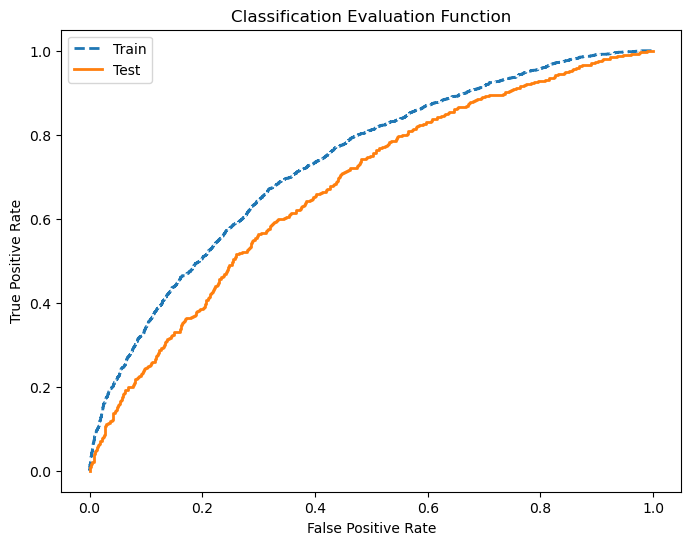

Training ROC AUC score: 0.7333139271340665
Testing ROC AUC score: 0.6755635037709118
Train Accuracy: 0.687
Test Accuracy: 0.667
Train Precision: 0.676
Test Precision: 0.554
Train Recall: 0.343
Test Recall: 0.288
Train F1 Score: 0.455
Test F1 Score: 0.379


In [35]:
classification_evaluation(best_rf, X_train, y_train, X_test, y_test)